label
ham     4825
spam     747
Name: count, dtype: int64


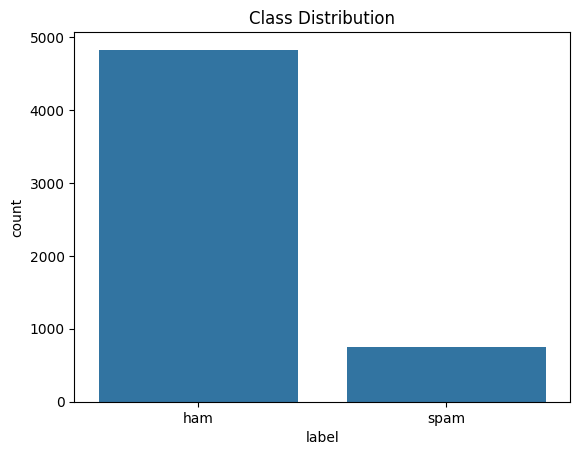

In [3]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# === Load and Clean Data ===
url = "https://raw.githubusercontent.com/gyq1985/nlp/main/spam.csv"
df = pd.read_csv(url, encoding='latin-1')
df = df[['spamORham', 'Message']].rename(columns={'spamORham': 'label', 'Message': 'text'})

# Check class distribution
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.show()

In [4]:
# === Encode Labels ===
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

X = df['text']
Y = df['label'].values.reshape(-1, 1)

# === Train/Test Split ===
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# === Tokenization ===
max_words = 5000
max_len = 150
tok = Tokenizer(num_words=max_words, oov_token='<OOV>')
tok.fit_on_texts(X_train)

X_train_seq = tok.texts_to_sequences(X_train)
X_test_seq = tok.texts_to_sequences(X_test)

X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)

# === Class Weights ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train.flatten())
class_weights = dict(enumerate(class_weights))

# === Model Definition ===
def build_model():
    inputs = Input(shape=(max_len,), name='inputs')
    x = Embedding(max_words, 64, input_length=max_len)(inputs)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(32)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid', name='output')(x)
    model = Model(inputs, x)
    return model

model = build_model()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 150, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 150, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,617 (1.40 MB)

 Trainable params: 367,617 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# === Train Model ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_pad, Y_train,
    batch_size=64,
    epochs=10,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 240ms/step - accuracy: 0.8164 - loss: 0.4963 - val_accuracy: 0.9694 - val_loss: 0.1294
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.9680 - loss: 0.1295 - val_accuracy: 0.9863 - val_loss: 0.0590
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step - accuracy: 0.9865 - loss: 0.0588 - val_accuracy: 0.9852 - val_loss: 0.0521
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.9933 - loss: 0.0328 - val_accuracy: 0.9842 - val_loss: 0.0568
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.9967 - loss: 0.0170 - val_accuracy: 0.9757 - val_loss: 0.0789
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.9977 - loss: 0.0120 - val_accuracy: 0.9747 - val_loss: 0.1175


In [6]:
# === Evaluate Model ===
loss, acc = model.evaluate(X_test_pad, Y_test, verbose=0)
print(f"\nTest Loss: {loss:.3f}  |  Test Accuracy: {acc:.3f}")

# === Classification Report ===
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(Y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


Test Loss: 0.074  |  Test Accuracy: 0.976
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       728
        spam       0.89      0.93      0.91       108

    accuracy                           0.98       836
   macro avg       0.94      0.95      0.95       836
weighted avg       0.98      0.98      0.98       836

Confusion Matrix:
[[716  12]
 [  8 100]]


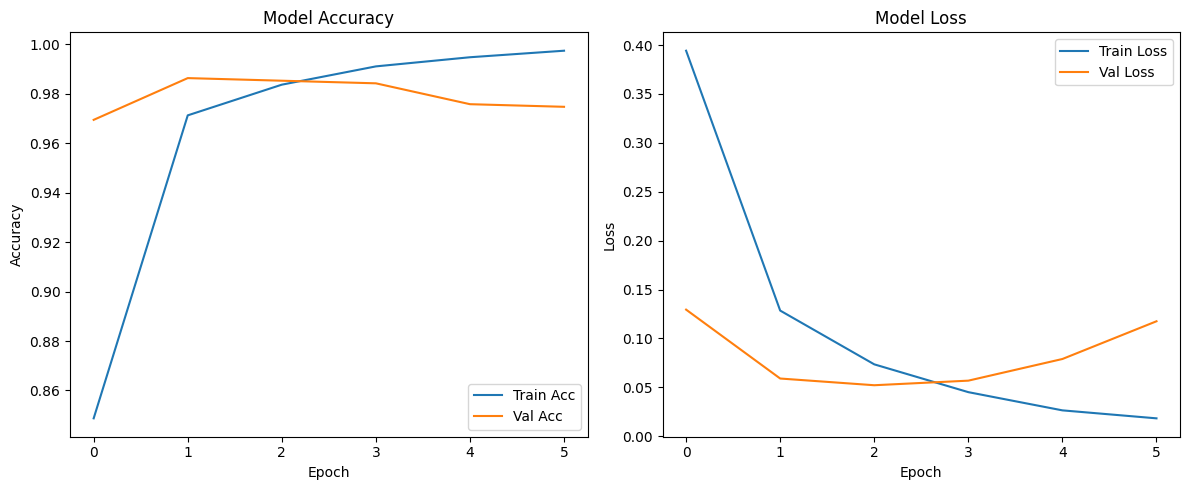

In [7]:
# === Accuracy & Loss Plot ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()